
This notebook contains a comprehensive analysis of the PLOD-CW-25 dataset and experiments with various deep learning models for abbreviation detection. The work is organized into three main sections:

1. Data Analysis
2. Experiment 1: Comparison of BiLSTM and BiLSTM-CRF Models
3. Experiment 2: BiLSTM Variants with Different Loss Functions and Optimizers
4. Experiment 3: BiLSTM with different vectorization 

In [1]:
! pip install datasets scikit-learn matplotlib seaborn torchcrf -q

You should consider upgrading via the 'C:\Users\HP\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [18]:
! pip install scikit-learn

In [24]:
! pip install torchcrf

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.scheme import IOB2
import torch.nn.functional as F
from TorchCRF import CRF
import copy
from itertools import chain

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu



In this section, we perform a comprehensive analysis of the PLOD-CW-25 dataset to understand:
1. Basic statistics and data distribution
2. Label distributions
3. Most common abbreviations and their long forms
4. Length analysis of abbreviations and long forms
5. Position analysis of abbreviations in sentences
6. Context analysis

In [5]:
#Dataset Loading and Initial Analysis

dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print("Successfully loaded PLOD-CW-25 dataset.")
print(dataset)

example = dataset["train"][0]
print("\nExample from train split:")
print("Tokens:", example["tokens"])
print("POS tags (raw):", example["pos_tags"])
print("NER tags (raw):", example["ner_tags"])

if hasattr(dataset["train"].features["ner_tags"], 'names'):
    ner_tag_names = dataset["train"].features["ner_tags"].names
    print("NER tag names from dataset:", ner_tag_names)
else:
    print("CRITICAL WARNING: Could not automatically determine ner_tag_names. Using default.")
    ner_tag_names = ['O', 'B-AC', 'B-LF', 'I-LF']

LABEL_TO_ID = {label: i for i, label in enumerate(ner_tag_names)}
ID_TO_LABEL = {i: label for i, label in enumerate(ner_tag_names)}
NUM_LABELS = len(ner_tag_names)

print(f"LABEL_TO_ID: {LABEL_TO_ID}")
print(f"ID_TO_LABEL: {ID_TO_LABEL}")
print(f"NUM_LABELS: {NUM_LABELS}")

all_tokens = [token for split in dataset for ex in dataset[split] for token in ex["tokens"]]
token_counts = Counter(all_tokens)
TOKEN_VOCAB = {token: i+2 for i, (token, _) in enumerate(token_counts.most_common())}
TOKEN_VOCAB["<PAD>"] = 0
TOKEN_VOCAB["<UNK>"] = 1
ID_TO_TOKEN = {i: token for token, i in TOKEN_VOCAB.items()}
TOKEN_VOCAB_SIZE = len(TOKEN_VOCAB)
print(f"Token Vocab Size: {TOKEN_VOCAB_SIZE}")

# Build POS tag vocabulary
all_pos_tags = [tag for split in dataset for ex in dataset[split] for tag in ex["pos_tags"]]
pos_tag_counts = Counter(all_pos_tags)
# Start POS ID from 1, reserve 0 for padding
POS_VOCAB = {tag: i+1 for i, (tag, _) in enumerate(pos_tag_counts.most_common())}
POS_VOCAB["<PAD>"] = 0 # Add padding token for POS tags
ID_TO_POS = {i: tag for tag, i in POS_VOCAB.items()}
POS_VOCAB_SIZE = len(POS_VOCAB)
print(f"POS Vocab Size: {POS_VOCAB_SIZE}")

Successfully loaded PLOD-CW-25 dataset.
DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

Example from train split:
Tokens: ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
POS tags (raw): ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
NER tags (raw): ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
CRITICAL WARNING: Could not automatically determine ner_tag_names. Using default.
LABEL_TO_ID: {'O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}
ID_TO_LABEL: {0: 'O', 1: 'B-AC', 2: 'B-LF', 3: 'I-LF'}
NUM_LABELS: 4
Token Vocab Size: 16493
POS Vocab Size: 18


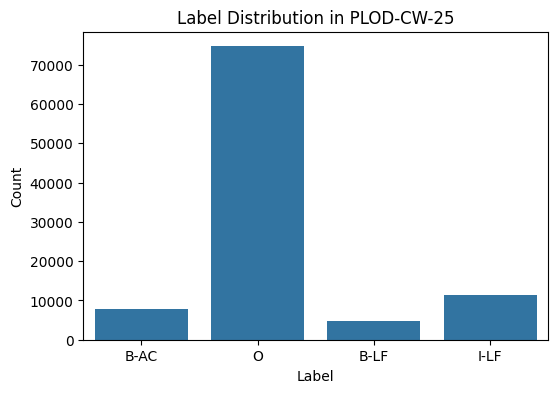

In [4]:
from collections import Counter

all_labels = []
for split in ['train', 'validation', 'test']:
    for tags in dataset[split]['ner_tags']:
        all_labels.extend(tags)
label_counts = Counter(all_labels)
plt.figure(figsize=(6,4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Label Distribution in PLOD-CW-25')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

Most common abbreviations: [('-', 330), ('CI', 61), ('WT', 47), ('HR', 40), ('OR', 40), ('/', 39), ('BMI', 39), ('GFP', 39), ('TB', 31), ('SD', 28)]
Most common long forms: [('confidence interval', 34), ('wild - type', 28), ('body mass index', 28), ('green fluorescent protein', 23), ('hazard ratio', 21), ('standard deviation', 18), ('odds ratio', 16), ('knockout', 14), ('World Health Organization', 12), ('antiretroviral therapy', 12)]


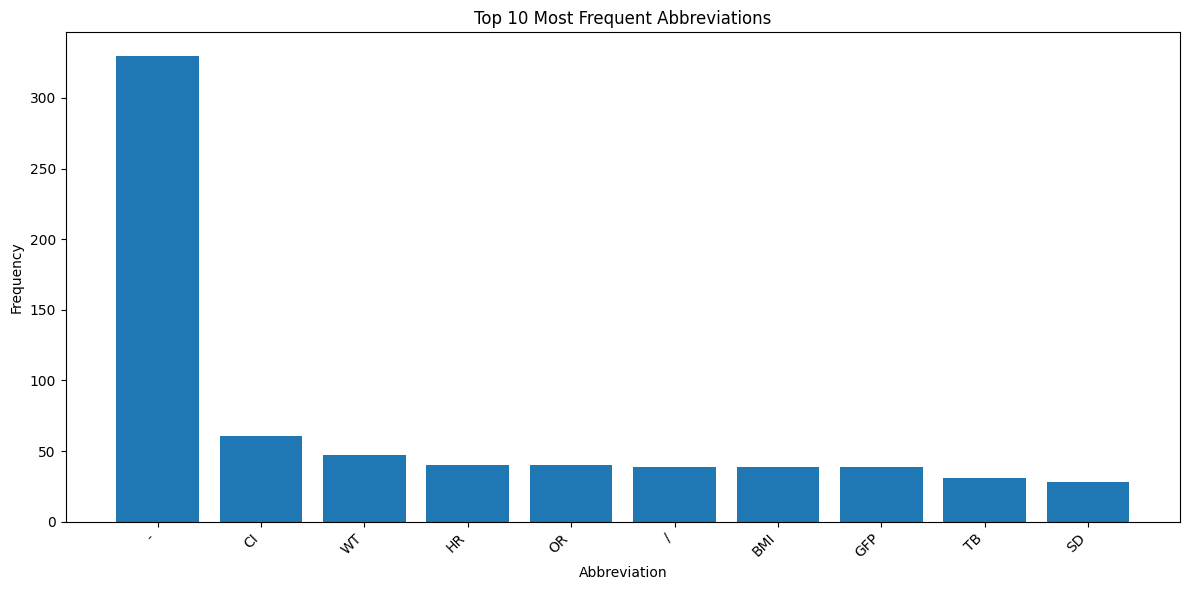

In [5]:
abbrev_counter = Counter()
longform_counter = Counter()
for tokens, tags in zip(dataset['train']['tokens'], dataset['train']['ner_tags']):
    i = 0
    while i < len(tags):
        if tags[i] == 'B-AC':
            abbrev_counter[tokens[i]] += 1
        elif tags[i] == 'B-LF':
            lf = [tokens[i]]
            j = i + 1
            while j < len(tags) and tags[j] == 'I-LF':
                lf.append(tokens[j])
                j += 1
            longform_counter[' '.join(lf)] += 1
            i = j - 1
        i += 1

print('Most common abbreviations:', abbrev_counter.most_common(10))
print('Most common long forms:', longform_counter.most_common(10))

plt.figure(figsize=(12, 6))
most_common_abbrevs = abbrev_counter.most_common(10)
abbrevs, counts = zip(*most_common_abbrevs)

# Create the bar chart
plt.bar(abbrevs, counts)
plt.title('Top 10 Most Frequent Abbreviations')
plt.xlabel('Abbreviation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

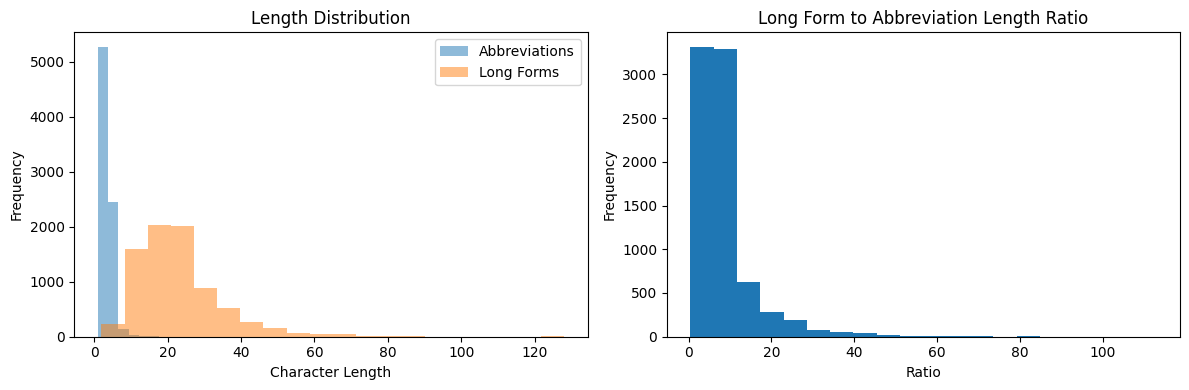

In [6]:
def analyze_lengths():
    abbrev_lengths = []
    longform_lengths = []
    ratios = []
    
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            i = 0
            while i < len(tags):
                if tags[i] == 'B-AC':
                    abbrev_len = len(tokens[i])
                    # Look for corresponding long form
                    j = 0
                    while j < len(tags):
                        if tags[j] == 'B-LF':
                            lf = []
                            k = j
                            while k < len(tags) and tags[k] in ['B-LF', 'I-LF']:
                                lf.append(tokens[k])
                                k += 1
                            lf_len = sum(len(word) for word in lf)
                            abbrev_lengths.append(abbrev_len)
                            longform_lengths.append(lf_len)
                            ratios.append(lf_len/abbrev_len)
                            break
                        j += 1
                i += 1
    
    return abbrev_lengths, longform_lengths, ratios

# Plot length distributions
abbrev_lens, longform_lens, ratios = analyze_lengths()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(abbrev_lens, bins=20, alpha=0.5, label='Abbreviations')
ax1.hist(longform_lens, bins=20, alpha=0.5, label='Long Forms')
ax1.set_title('Length Distribution')
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(ratios, bins=20)
ax2.set_title('Long Form to Abbreviation Length Ratio')
ax2.set_xlabel('Ratio')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

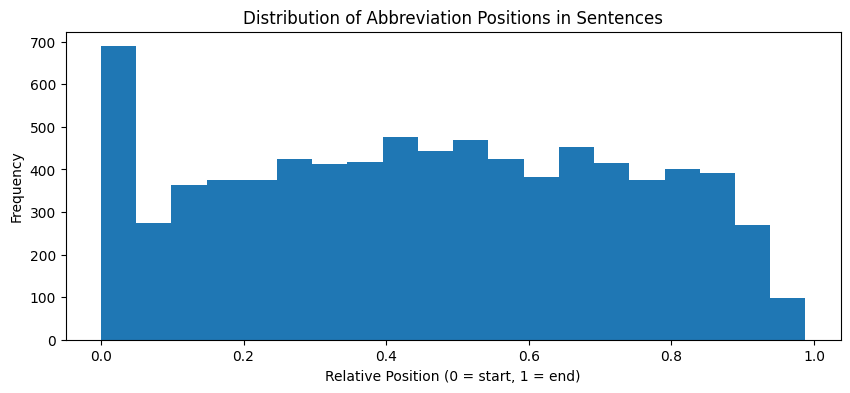

Mean position: 0.46
Median position: 0.46
Most common position range: 0.46


In [7]:
def analyze_positions():
    positions = []
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            for i, tag in enumerate(tags):
                if tag == 'B-AC':
                    # Calculate relative position (0 to 1)
                    position = i / len(tokens)
                    positions.append(position)
    return positions

# Plot position distribution
positions = analyze_positions()
plt.figure(figsize=(10, 4))
plt.hist(positions, bins=20)
plt.title('Distribution of Abbreviation Positions in Sentences')
plt.xlabel('Relative Position (0 = start, 1 = end)')
plt.ylabel('Frequency')
plt.show()

# Print position statistics
print(f"Mean position: {np.mean(positions):.2f}")
print(f"Median position: {np.median(positions):.2f}")
print(f"Most common position range: {np.percentile(positions, 50):.2f}")

## Experiment 1
In this experiment, we compare two neural architectures:
1. Basic BiLSTM model
2. BiLSTM with CRF layer

We'll evaluate their performance on the abbreviation detection task.

In [8]:
train_data = dataset["train"]
test_data = dataset["test"]

# Create vocabularies
all_tokens = list(chain(*train_data["tokens"]))
all_tags = list(chain(*train_data["ner_tags"]))

token2idx = {tok: i+2 for i, tok in enumerate(set(all_tokens))}
token2idx["<PAD>"] = 0
token2idx["<UNK>"] = 1

tag_set = sorted(set(all_tags))
tag2idx = {tag: i for i, tag in enumerate(tag_set)}
idx2tag = {i: tag for tag, i in tag2idx.items()}

def encode_and_pad(data, pad_token_id=0, pad_label_id=-100):
    inputs, labels = [], []
    for tokens, tags in zip(data["tokens"], data["ner_tags"]):
        input_ids = [token2idx.get(tok, token2idx["<UNK>"]) for tok in tokens]
        label_ids = [tag2idx[tag] for tag in tags]
        inputs.append(input_ids)
        labels.append(label_ids)

    max_len = max(len(seq) for seq in inputs)
    inputs = [seq + [pad_token_id]*(max_len - len(seq)) for seq in inputs]
    labels = [seq + [pad_label_id]*(max_len - len(seq)) for seq in labels]
    return inputs, labels

train_inputs, train_labels = encode_and_pad(train_data)
test_inputs, test_labels = encode_and_pad(test_data)

In [9]:
class NERDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

train_dataset = NERDataset(train_inputs, train_labels)
test_dataset = NERDataset(test_inputs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=32, hidden_dim=64):
        super(BiLSTMTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, input_ids):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        logits = self.fc(lstm_out)
        return logits

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=32, hidden_dim=64, pad_token_id=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size)

    def _get_emissions(self, input_ids):
        x, _ = self.lstm(self.embedding(input_ids))
        return self.fc(x)

    def forward(self, input_ids):
        emissions = self._get_emissions(input_ids)
        mask = (input_ids != self.embedding.padding_idx)
        return self.crf.viterbi_decode(emissions, mask)

    def loss(self, input_ids, tags):
        emissions = self._get_emissions(input_ids)
        mask = (input_ids != self.embedding.padding_idx)
        log_likelihood = self.crf.forward(emissions, tags, mask)
        return -log_likelihood.mean()

In [12]:
from sklearn.metrics import f1_score
import time

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            logits = model(input_ids)
            preds = torch.argmax(logits, dim=-1)
            for p, l in zip(preds, labels):
                p = p.cpu().numpy()
                l = l.cpu().numpy()
                valid = l != -100
                all_preds.extend(p[valid])
                all_labels.extend(l[valid])
    model.train()
    return f1_score(all_labels, all_preds, average="macro")

bilstm_model = BiLSTMTagger(len(token2idx), len(tag2idx))
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=2e-3)

In [13]:
# Train BiLSTM
print("Training BiLSTM model...")

for epoch in range(20):
    start_time = time.time()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        labels = batch["labels"]

        logits = bilstm_model(input_ids)
        loss = loss_fn(logits.view(-1, len(tag2idx)), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    test_f1 = evaluate(bilstm_model, test_loader)
    duration = time.time() - start_time
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Test F1: {test_f1:.4f}, Time: {duration:.2f}s")

Training BiLSTM model...
Epoch 1, Loss: 52.9389, Test F1: 0.2585, Time: 123.67s
Epoch 1, Loss: 52.9389, Test F1: 0.2585, Time: 123.67s
Epoch 2, Loss: 35.4086, Test F1: 0.5781, Time: 56.05s
Epoch 2, Loss: 35.4086, Test F1: 0.5781, Time: 56.05s
Epoch 3, Loss: 28.4802, Test F1: 0.6695, Time: 60.58s
Epoch 3, Loss: 28.4802, Test F1: 0.6695, Time: 60.58s
Epoch 4, Loss: 25.1399, Test F1: 0.7101, Time: 57.11s
Epoch 4, Loss: 25.1399, Test F1: 0.7101, Time: 57.11s
Epoch 5, Loss: 22.1175, Test F1: 0.7391, Time: 55.68s
Epoch 5, Loss: 22.1175, Test F1: 0.7391, Time: 55.68s
Epoch 6, Loss: 19.3041, Test F1: 0.7486, Time: 65.47s
Epoch 6, Loss: 19.3041, Test F1: 0.7486, Time: 65.47s
Epoch 7, Loss: 17.1682, Test F1: 0.7564, Time: 63.05s
Epoch 7, Loss: 17.1682, Test F1: 0.7564, Time: 63.05s
Epoch 8, Loss: 15.2171, Test F1: 0.7602, Time: 68.88s
Epoch 8, Loss: 15.2171, Test F1: 0.7602, Time: 68.88s
Epoch 9, Loss: 13.5537, Test F1: 0.7577, Time: 68.11s
Epoch 9, Loss: 13.5537, Test F1: 0.7577, Time: 68.11s
E

In [ ]:
! pip install -U TorchCRF

In [14]:
PAD_TOKEN_ID = token2idx["<PAD>"]
PAD_LABEL_ID = tag2idx["O"]

train_inputs, train_labels = encode_and_pad(train_data, PAD_TOKEN_ID, PAD_LABEL_ID)
test_inputs,  test_labels  = encode_and_pad(test_data,  PAD_TOKEN_ID, PAD_LABEL_ID)

train_loader = DataLoader(NERDataset(train_inputs, train_labels), batch_size=32, shuffle=True)
test_loader  = DataLoader(NERDataset(test_inputs,  test_labels),  batch_size=32)

In [17]:
def evaluateBiLSTMCRF(model, loader):
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"]
            labels    = batch["labels"]
            batch_preds = model(input_ids)
            for pred_seq, label_seq, inp_seq in zip(batch_preds,
                                                    labels,
                                                    input_ids):
                valid_len = (inp_seq != PAD_TOKEN_ID).sum().item()
                preds_all.extend(pred_seq[:valid_len])
                labels_all.extend(label_seq[:valid_len].tolist())
    model.train()
    return f1_score(labels_all, preds_all, average="macro")

In [18]:
print("\nTraining BiLSTM-CRF model...")
crf_model = BiLSTM_CRF(len(token2idx), len(tag2idx), pad_token_id=0)
optimizer = torch.optim.Adam(crf_model.parameters(), lr=2e-3)

for epoch in range(20):
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        loss = crf_model.loss(batch["input_ids"], batch["labels"])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    test_f1 = evaluateBiLSTMCRF(crf_model, test_loader)
    print(f"Epoch {epoch+1:2d} | Loss: {total_loss:.4f} | Test F1: {test_f1:.4f}")


Training BiLSTM-CRF model...
Epoch  1 | Loss: 2211.1579 | Test F1: 0.2169
Epoch  2 | Loss: 1443.5996 | Test F1: 0.4594
Epoch  3 | Loss: 1096.3063 | Test F1: 0.6072
Epoch  4 | Loss: 907.0009 | Test F1: 0.7049
Epoch  5 | Loss: 779.0028 | Test F1: 0.6907
Epoch  6 | Loss: 674.7527 | Test F1: 0.6989
Epoch  7 | Loss: 586.9062 | Test F1: 0.7167
Epoch  8 | Loss: 516.3122 | Test F1: 0.7070
Epoch  9 | Loss: 449.0275 | Test F1: 0.7053
Epoch 10 | Loss: 395.1512 | Test F1: 0.7136
Epoch 11 | Loss: 340.4134 | Test F1: 0.7202
Epoch 12 | Loss: 291.8848 | Test F1: 0.7117
Epoch 13 | Loss: 251.6854 | Test F1: 0.6921
Epoch 14 | Loss: 218.1078 | Test F1: 0.6686
Epoch 15 | Loss: 186.3510 | Test F1: 0.6842
Epoch 16 | Loss: 159.7636 | Test F1: 0.7023
Epoch 17 | Loss: 182.3615 | Test F1: 0.6618
Epoch 18 | Loss: 220.4217 | Test F1: 0.6559
Epoch 19 | Loss: 179.3345 | Test F1: 0.6782
Epoch 20 | Loss: 127.8995 | Test F1: 0.7016


## Experiment 2

We evaluated their performance on the abbreviation detection task.
In this experiment, we explore different variants of the Optimizer and Loss Function:
1. BiLSTM + CrossEntropyLoss + Adam
2. BiLSTM + Focal Loss + AdamW
3. BiLSTM + Label Smoothing Loss + SGD

In [20]:
# Data Preprocessing & DataLoader
class PlodTokenClassificationDataset(Dataset):
    def __init__(self, examples, token_vocab, pos_vocab, label_to_id):
        self.tokens = []
        self.pos_tags_data = []
        self.labels = []
        # Determine if NER tags are strings or integers based on the first example
        sample_ner_tags = examples[0]["ner_tags"]
        are_ner_tags_strings = isinstance(sample_ner_tags[0], str)
        if are_ner_tags_strings: print("Detected NER tags in source data are STRINGS.")
        else: print("Detected NER tags in source data are INTEGERS.")

        for example in examples:
            self.tokens.append([token_vocab.get(tok, token_vocab["<UNK>"]) for tok in example["tokens"]])
            current_ner_tags = example["ner_tags"]
            if are_ner_tags_strings:
                self.labels.append([label_to_id.get(tag, label_to_id.get('O', 0)) for tag in current_ner_tags])
            else:
                # Assume integer tags are already correct IDs or require mapping
                # If they are raw dataset integers, this might need adjustment
                self.labels.append([int(tag) for tag in current_ner_tags])

            # Map string POS tags to integer IDs using the POS vocabulary
            self.pos_tags_data.append([pos_vocab.get(p, pos_vocab["<PAD>"]) for p in example["pos_tags"]])


    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return {"tokens": self.tokens[idx], "pos_tags": self.pos_tags_data[idx], "labels": self.labels[idx]}

def collate_fn(batch):
    tokens_list = [torch.tensor(item["tokens"]) for item in batch]
    pos_tags_list = [torch.tensor(item["pos_tags"]) for item in batch]
    labels_list = [torch.tensor(item["labels"]) for item in batch]
    padded_tokens = nn.utils.rnn.pad_sequence(tokens_list, batch_first=True, padding_value=TOKEN_VOCAB["<PAD>"])
    # Use POS_VOCAB["<PAD>"] as padding value for POS tags
    padded_pos_tags = nn.utils.rnn.pad_sequence(pos_tags_list, batch_first=True, padding_value=POS_VOCAB["<PAD>"])
    padded_labels = nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-100)
    return {"tokens": padded_tokens.to(DEVICE), "pos_tags": padded_pos_tags.to(DEVICE), "labels": padded_labels.to(DEVICE)}

# Pass the POS_VOCAB to the dataset constructor
train_dataset = PlodTokenClassificationDataset(dataset["train"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)
val_dataset = PlodTokenClassificationDataset(dataset["validation"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)
test_dataset = PlodTokenClassificationDataset(dataset["test"], TOKEN_VOCAB, POS_VOCAB, LABEL_TO_ID)


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"Train Dataloader: {len(train_dataloader)} batches, Val: {len(val_dataloader)}, Test: {len(test_dataloader)}")
batch_sample = next(iter(train_dataloader))
print("\nSample batch shapes: Tokens:", batch_sample["tokens"].shape, "POS:", batch_sample["pos_tags"].shape, "Labels:", batch_sample["labels"].shape)


Detected NER tags in source data are STRINGS.
Detected NER tags in source data are STRINGS.
Detected NER tags in source data are STRINGS.
Train Dataloader: 63 batches, Val: 5, Test: 8

Sample batch shapes: Tokens: torch.Size([32, 68]) POS: torch.Size([32, 68]) Labels: torch.Size([32, 68])


In [21]:

#  Model
class BiLSTMPOSTag(nn.Module):
    def __init__(self, token_vocab_size, token_embedding_dim, pos_vocab_size, pos_embedding_dim, hidden_dim, num_labels, dropout_rate=0.3):
        super().__init__()
        self.token_embedding = nn.Embedding(token_vocab_size, token_embedding_dim, padding_idx=TOKEN_VOCAB["<PAD>"])
        # Ensure POS embedding uses the correct vocab size and padding idx
        self.pos_embedding = nn.Embedding(pos_vocab_size, pos_embedding_dim, padding_idx=POS_VOCAB["<PAD>"])
        self.embedding_dim = token_embedding_dim + pos_embedding_dim
        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, tokens, pos_tags):
        token_embedded = self.token_embedding(tokens)
        pos_embedded = self.pos_embedding(pos_tags)
        combined_embeddings = torch.cat((token_embedded, pos_embedded), dim=2)
        lstm_out, _ = self.lstm(combined_embeddings)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)
        return logits

TOKEN_EMBEDDING_DIM = 100
POS_EMBEDDING_DIM = 25
HIDDEN_DIM = 128
DROPOUT_RATE = 0.33

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        num_classes = logits.size(-1)
        logits_flat = logits.view(-1, num_classes)
        targets_flat = targets.view(-1)
        mask = (targets_flat != self.ignore_index)
        logits_filtered = logits_flat[mask]
        targets_filtered = targets_flat[mask]
        if logits_filtered.numel() == 0: return torch.tensor(0.0, device=logits.device, requires_grad=True)
        log_probs = F.log_softmax(logits_filtered, dim=1)
        probs = torch.exp(log_probs)
        pt = probs.gather(1, targets_filtered.unsqueeze(1)).squeeze(1)
        ce_loss = F.cross_entropy(logits_filtered, targets_filtered, reduction='none', 
                                weight=self.alpha.to(logits.device) if self.alpha is not None else None)
        focal_term = (1 - pt)**self.gamma
        loss = focal_term * ce_loss
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.confidence = 1.0 - smoothing

    def forward(self, logits, targets):
        logits_flat = logits.view(-1, self.num_classes)
        targets_flat = targets.view(-1)
        mask = (targets_flat != self.ignore_index)
        logits_masked = logits_flat[mask]
        targets_masked = targets_flat[mask]
        if logits_masked.numel() == 0: return torch.tensor(0.0, device=logits.device, requires_grad=True)
        log_probs = F.log_softmax(logits_masked, dim=1)
        smooth_targets_dist = torch.full_like(log_probs, self.smoothing / (self.num_classes - 1))
        smooth_targets_dist.scatter_(1, targets_masked.unsqueeze(1), self.confidence)
        loss = -torch.sum(smooth_targets_dist * log_probs, dim=1)
        return loss.mean()

In [23]:
# Training and Evaluation Utilities
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        tokens, pos_tags, labels = batch["tokens"], batch["pos_tags"], batch["labels"]
        optimizer.zero_grad()
        logits = model(tokens, pos_tags)
        loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion, id_to_label_map):
    model.eval()
    epoch_loss = 0
    all_true_labels_sequences, all_pred_labels_sequences = [], []
    with torch.no_grad():
        for batch in dataloader:
            tokens, pos_tags, labels = batch["tokens"], batch["pos_tags"], batch["labels"]
            logits = model(tokens, pos_tags)
            loss = criterion(logits.view(-1, NUM_LABELS), labels.view(-1))
            epoch_loss += loss.item()
            predictions = torch.argmax(logits, dim=2)
            for i in range(labels.size(0)):
                true_seq, pred_seq = [], []
                for j in range(labels.size(1)):
                    if labels[i, j].item() != -100:
                        true_seq.append(id_to_label_map[labels[i, j].item()])
                        pred_seq.append(id_to_label_map[predictions[i, j].item()])
                if true_seq:
                    all_true_labels_sequences.append(true_seq)
                    all_pred_labels_sequences.append(pred_seq)
    avg_loss = epoch_loss / len(dataloader)
    report_dict = seqeval_classification_report(all_true_labels_sequences, all_pred_labels_sequences, output_dict=True, mode='strict', scheme=IOB2, zero_division=0)
    flat_true = [label for seq in all_true_labels_sequences for label in seq]
    flat_pred = [label for seq in all_pred_labels_sequences for label in seq]
    cm_labels = sorted(list(set(flat_true + flat_pred)))
    if not cm_labels: cm_labels = list(id_to_label_map.values())
    return avg_loss, report_dict, all_true_labels_sequences, all_pred_labels_sequences, cm_labels


In [24]:


# train
NUM_EPOCHS = 10
LEARNING_RATE_ADAM = 1e-3
LEARNING_RATE_ADAMW = 1e-3
LEARNING_RATE_SGD = 1e-2
all_experiment_results = {}

#  A: BiLSTM + CrossEntropyLoss + Adam
print("\n---  A: BiLSTM + CrossEntropyLoss + Adam ---")
model_A = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_A = nn.CrossEntropyLoss(ignore_index=-100)
optimizer_A = optim.Adam(model_A.parameters(), lr=LEARNING_RATE_ADAM)
history_A = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_A, train_dataloader, optimizer_A, criterion_A)
    val_loss, val_report, _, _, _ = evaluate(model_A, val_dataloader, criterion_A, ID_TO_LABEL)
    history_A['train_loss'].append(train_loss); history_A['val_loss'].append(val_loss)
    history_A['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"A - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + CrossEntropyLoss + Adam'] = {'model': model_A, 'history': history_A, 'criterion': criterion_A, 'optimizer_type': 'Adam'}

#  B: BiLSTM + Focal Loss + AdamW
print("\n---  B: BiLSTM + Focal Loss + AdamW ---")
model_B = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_B = FocalLoss(alpha=None, gamma=2.0, ignore_index=-100)
optimizer_B = optim.AdamW(model_B.parameters(), lr=LEARNING_RATE_ADAMW)
history_B = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_B, train_dataloader, optimizer_B, criterion_B)
    val_loss, val_report, _, _, _ = evaluate(model_B, val_dataloader, criterion_B, ID_TO_LABEL)
    history_B['train_loss'].append(train_loss); history_B['val_loss'].append(val_loss)
    history_B['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"B - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + Focal Loss + AdamW'] = {'model': model_B, 'history': history_B, 'criterion': criterion_B, 'optimizer_type': 'AdamW'}

#  C: BiLSTM + Label Smoothing Loss + SGD
print("\n---  C: BiLSTM + Label Smoothing Loss + SGD ---")
model_C = BiLSTMPOSTag(TOKEN_VOCAB_SIZE, TOKEN_EMBEDDING_DIM, POS_VOCAB_SIZE, POS_EMBEDDING_DIM, HIDDEN_DIM, NUM_LABELS, DROPOUT_RATE).to(DEVICE)
criterion_C = LabelSmoothingLoss(num_classes=NUM_LABELS, smoothing=0.1, ignore_index=-100)
optimizer_C = optim.SGD(model_C.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9)
history_C = {'train_loss': [], 'val_loss': [], 'val_f1': []}
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_C, train_dataloader, optimizer_C, criterion_C)
    val_loss, val_report, _, _, _ = evaluate(model_C, val_dataloader, criterion_C, ID_TO_LABEL)
    history_C['train_loss'].append(train_loss); history_C['val_loss'].append(val_loss)
    history_C['val_f1'].append(val_report['micro avg']['f1-score'])
    print(f"C - Ep {epoch+1}: Tr Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_report['micro avg']['f1-score']:.4f}")
all_experiment_results['BiLSTM + Label Smoothing Loss + SGD'] = {'model': model_C, 'history': history_C, 'criterion': criterion_C, 'optimizer_type': 'SGD'}



---  A: BiLSTM + CrossEntropyLoss + Adam ---
A - Ep 1: Tr Loss: 0.6738, Val Loss: 0.4585, Val F1: 0.5239
A - Ep 2: Tr Loss: 0.3806, Val Loss: 0.3695, Val F1: 0.6428
A - Ep 3: Tr Loss: 0.3015, Val Loss: 0.3495, Val F1: 0.6965
A - Ep 4: Tr Loss: 0.2608, Val Loss: 0.3535, Val F1: 0.7125
A - Ep 5: Tr Loss: 0.2341, Val Loss: 0.3488, Val F1: 0.7028
A - Ep 6: Tr Loss: 0.2042, Val Loss: 0.3666, Val F1: 0.7112
A - Ep 7: Tr Loss: 0.1766, Val Loss: 0.3643, Val F1: 0.7179
A - Ep 8: Tr Loss: 0.1493, Val Loss: 0.3805, Val F1: 0.7098
A - Ep 9: Tr Loss: 0.1288, Val Loss: 0.4103, Val F1: 0.7066
A - Ep 10: Tr Loss: 0.1023, Val Loss: 0.4277, Val F1: 0.6974

---  B: BiLSTM + Focal Loss + AdamW ---
B - Ep 1: Tr Loss: 0.3128, Val Loss: 0.1972, Val F1: 0.5394
B - Ep 2: Tr Loss: 0.1584, Val Loss: 0.1494, Val F1: 0.6540
B - Ep 3: Tr Loss: 0.1198, Val Loss: 0.1382, Val F1: 0.6685
B - Ep 4: Tr Loss: 0.1017, Val Loss: 0.1337, Val F1: 0.6586
B - Ep 5: Tr Loss: 0.0880, Val Loss: 0.1345, Val F1: 0.6720
B - Ep 6: Tr


--- 7. Evaluation & Result Plotting ---


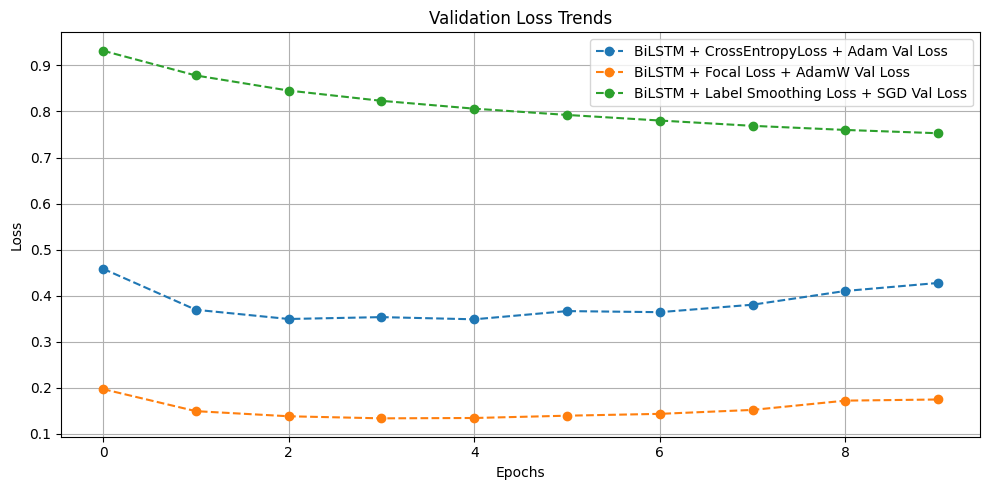

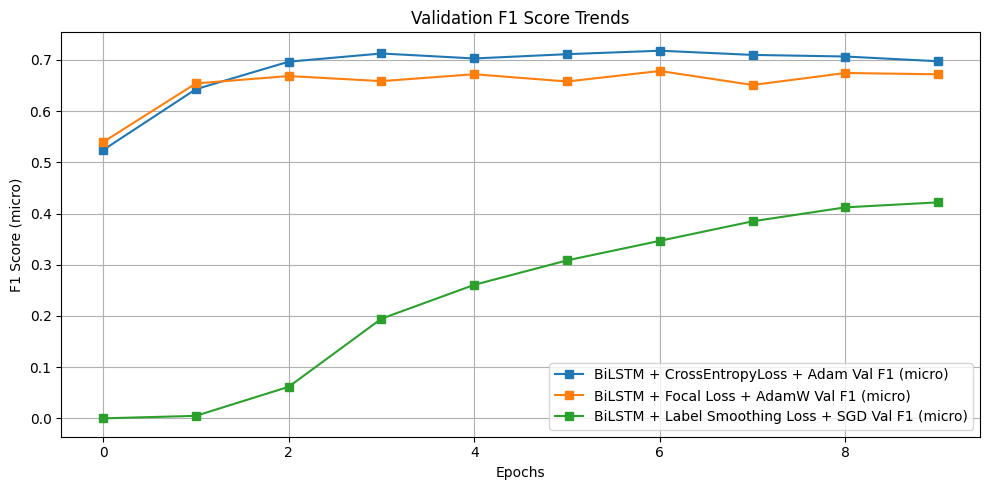


--- Detailed Test Set Evaluation ---

--- Evaluating BiLSTM + CrossEntropyLoss + Adam on Test Set ---
BiLSTM + CrossEntropyLoss + Adam - Test Loss: 0.3453, Micro F1: 0.7102, Macro F1: 0.6937
              precision    recall  f1-score   support

          AC       0.78      0.75      0.76       797
          LF       0.62      0.62      0.62       482

   micro avg       0.72      0.70      0.71      1279
   macro avg       0.70      0.69      0.69      1279
weighted avg       0.72      0.70      0.71      1279



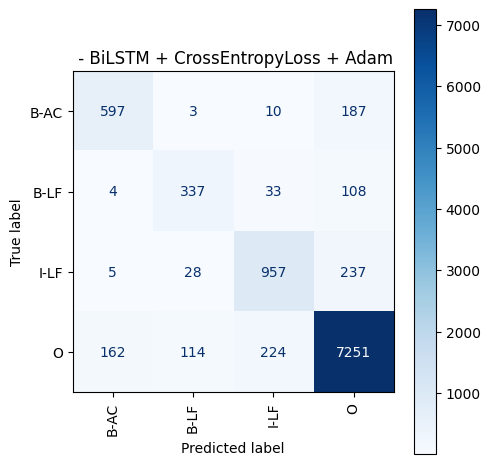


--- Evaluating BiLSTM + Focal Loss + AdamW on Test Set ---
BiLSTM + Focal Loss + AdamW - Test Loss: 0.1475, Micro F1: 0.6953, Macro F1: 0.6746
              precision    recall  f1-score   support

          AC       0.83      0.70      0.76       797
          LF       0.63      0.55      0.59       482

   micro avg       0.75      0.65      0.70      1279
   macro avg       0.73      0.63      0.67      1279
weighted avg       0.76      0.65      0.70      1279



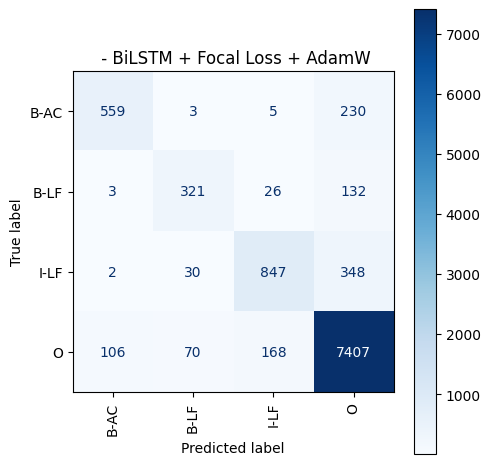


--- Evaluating BiLSTM + Label Smoothing Loss + SGD on Test Set ---
BiLSTM + Label Smoothing Loss + SGD - Test Loss: 0.7312, Micro F1: 0.4222, Macro F1: 0.3084
              precision    recall  f1-score   support

          AC       0.65      0.48      0.55       797
          LF       0.67      0.03      0.06       482

   micro avg       0.65      0.31      0.42      1279
   macro avg       0.66      0.26      0.31      1279
weighted avg       0.66      0.31      0.37      1279



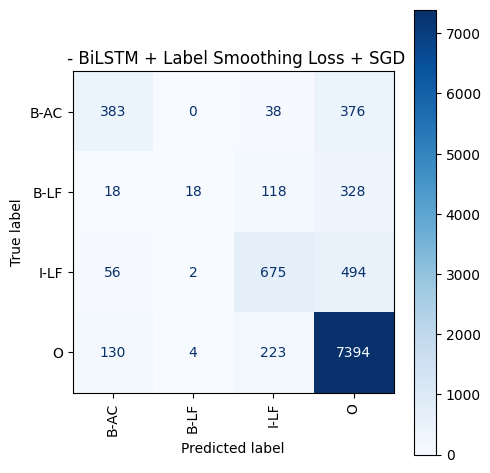

In [25]:

# Evaluation & Result Plotting
print("\n--- 7. Evaluation & Result Plotting ---")
plt.figure(figsize=(10, 5))
for name, results in all_experiment_results.items():
    plt.plot(results['history']['val_loss'], label=f"{name} Val Loss", marker='o', linestyle='--')
plt.title('Validation Loss Trends'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
for name, results in all_experiment_results.items():
    plt.plot(results['history']['val_f1'], label=f"{name} Val F1 (micro)", marker='s')
plt.title('Validation F1 Score Trends'); plt.xlabel('Epochs'); plt.ylabel('F1 Score (micro)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("\n--- Detailed Test Set Evaluation ---")
test_reports_summary = {}
for name, results in all_experiment_results.items():
    print(f"\n--- Evaluating {name} on Test Set ---")
    model_to_test = results['model']; criterion_for_eval = results['criterion']
    test_loss, test_report_dict, test_true_seqs, test_pred_seqs, cm_labels_test = evaluate(model_to_test, test_dataloader, criterion_for_eval, ID_TO_LABEL)
    test_reports_summary[name] = {
        'loss': test_loss, 'report_dict': test_report_dict,
        'micro_f1': test_report_dict.get('micro avg', {}).get('f1-score', 0),
        'macro_f1': test_report_dict.get('macro avg', {}).get('f1-score', 0)}
    print(f"{name} - Test Loss: {test_loss:.4f}, Micro F1: {test_reports_summary[name]['micro_f1']:.4f}, Macro F1: {test_reports_summary[name]['macro_f1']:.4f}")
    print(seqeval_classification_report(test_true_seqs, test_pred_seqs, mode='strict', scheme=IOB2, zero_division=0))
    flat_true_test = [label for seq in test_true_seqs for label in seq]
    flat_pred_test = [label for seq in test_pred_seqs for label in seq]
    if not cm_labels_test and (flat_true_test or flat_pred_test): cm_labels_test = sorted(list(set(flat_true_test + flat_pred_test)))
    elif not cm_labels_test: cm_labels_test = sorted(list(ID_TO_LABEL.values()))
    if flat_true_test and flat_pred_test:
        try:
            cm = confusion_matrix(flat_true_test, flat_pred_test, labels=cm_labels_test)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels_test)
            fig, ax = plt.subplots(figsize=(max(5, len(cm_labels_test)//1.5), max(5, len(cm_labels_test)//1.5)))
            disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues'); plt.title(f' - {name}'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"CM plot error for {name}: {e}")
    else: print(f"No data for CM for {name}.")



## Experiment 3

In this experiment, we used different vectorization method with BiLSTM, including 
1. BiLSTM with word2vec 
2. BiLSTM with GloVe 


In [59]:
data_train= dataset['train']
data_validation=dataset['validation']
data_test=dataset['test']

In [60]:
## Preprocessing

from collections import Counter

# NER Tags mapping (safe way)
if hasattr(dataset["train"].features["ner_tags"], "feature") and hasattr(dataset["train"].features["ner_tags"].feature, "names"):
    ner_tag_names = dataset["train"].features["ner_tags"].feature.names
else:
    # Manual fallback: put your actual label names here if available
    ner_tag_names = ['O', 'B-AC', 'B-LF', 'I-LF']

LABEL_TO_ID = {label: i for i, label in enumerate(ner_tag_names)}
ID_TO_LABEL = {i: label for label, i in LABEL_TO_ID.items()}

# Token Vocabulary
all_tokens = [token for split in dataset for ex in dataset[split] for token in ex["tokens"]]
token_counts = Counter(all_tokens)
TOKEN_VOCAB = {token: i+2 for i, (token, _) in enumerate(token_counts.most_common())}
TOKEN_VOCAB["<PAD>"] = 0
TOKEN_VOCAB["<UNK>"] = 1
ID_TO_TOKEN = {i: token for token, i in TOKEN_VOCAB.items()}

# POS Vocabulary
all_pos_tags = [tag for split in dataset for ex in dataset[split] for tag in ex["pos_tags"]]
pos_tag_counts = Counter(all_pos_tags)
POS_VOCAB = {tag: i+1 for i, (tag, _) in enumerate(pos_tag_counts.most_common())}
POS_VOCAB["<PAD>"] = 0
ID_TO_POS = {i: tag for tag, i in POS_VOCAB.items()}

print("Preprocessing done")

Preprocessing done


In [61]:
# Labels encoders
label_encoding = {"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list = []
for sample in data_train["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in data_validation["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in data_test["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])

In [9]:
#Importing Word2vec Model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

In [63]:
# Dataset Class
class PlodTokenDataset(Dataset):
    def __init__(self, tokens, labels, model):
        self.tokens = tokens
        self.labels = labels
        self.model = model

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words = self.tokens[idx]
        embeddings = [self.model[word] if word in self.model else np.zeros(300) for word in words]
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float)
        labels_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"tokens": embeddings_tensor, "labels": labels_tensor}


# Custom collate_fn
def collate_fn(batch):
    # Padded token sequences
    tokens_list = [item["tokens"] for item in batch]
    labels_list = [item["labels"] for item in batch]

    # Pad token sequences to ensure all sequences are the same length
    padded_tokens = nn.utils.rnn.pad_sequence(tokens_list, batch_first=True, padding_value=0)

    # Pad labels
    padded_labels = nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-1)

    return {"tokens": padded_tokens.to(DEVICE), "labels": padded_labels.to(DEVICE)}


In [64]:
# Training Data
bilstm_dataset =  PlodTokenDataset(data_train['tokens'], label_list, word2vec_model)
bilstm_dataloader = DataLoader(bilstm_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Testing Data
bilstm_dataset_test = PlodTokenDataset(data_test['tokens'], test_label_list, word2vec_model)
bilstm_dataloader_test = DataLoader(bilstm_dataset_test, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [65]:
#BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out)
        tag_scores = torch.log_softmax(tag_space, dim=-1)
        return tag_scores

In [66]:
bilstm_model=BiLSTM(embedding_dim=300,hidden_dim=150,tagset_size=4)

In [67]:
optimizer = optim.Adam(bilstm_model.parameters(),lr=0.001)
loss_function = nn.NLLLoss(ignore_index=-1)  # Ignoring padding index (-1) in the loss calculation

# Training loop
for epoch in range(20):
    bilstm_model.train()
    for batch in bilstm_dataloader: # iterate over batches in bilstm_dataloader
        optimizer.zero_grad()
        # Get inputs (tokens) and labels from the current batch
        inputs = batch["tokens"]
        labels = batch["labels"]

        outputs = bilstm_model(inputs)

        loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
        loss.backward()
        optimizer.step() # calling the function optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.71833336353302
Epoch 2, Loss: 0.6972897052764893
Epoch 3, Loss: 0.6430888772010803
Epoch 4, Loss: 0.5058455467224121
Epoch 5, Loss: 0.555047869682312
Epoch 6, Loss: 0.3717051148414612
Epoch 7, Loss: 0.33687445521354675
Epoch 8, Loss: 0.4447087049484253
Epoch 9, Loss: 0.38230058550834656
Epoch 10, Loss: 0.3562934696674347
Epoch 11, Loss: 0.3432173430919647
Epoch 12, Loss: 0.3596017360687256
Epoch 13, Loss: 0.32956719398498535
Epoch 14, Loss: 0.1829659789800644
Epoch 15, Loss: 0.3094229996204376
Epoch 16, Loss: 0.2962852418422699
Epoch 17, Loss: 0.22405926883220673
Epoch 18, Loss: 0.33132097125053406
Epoch 19, Loss: 0.2379283607006073
Epoch 20, Loss: 0.4132222831249237


In [86]:
from sklearn.metrics import classification_report, confusion_matrix
# Testing and evaluation
bilstm_model.eval()
bilstm_preds = []
bilstm_labels = []
with torch.no_grad():
    for batch in bilstm_dataloader_test: 
        inputs = batch["tokens"]  
        labels = batch["labels"]  
        outputs = bilstm_model(inputs)
        _, predicted = torch.max(outputs, -1)
        bilstm_preds.extend(predicted.view(-1).tolist())
        bilstm_labels.extend(labels.view(-1).tolist())

# Filtering out padded
filtered_preds = [p for p, l in zip(bilstm_preds, bilstm_labels) if l != -1]
filtered_labels = [l for l in bilstm_labels if l != -1]

print(classification_report(filtered_labels, filtered_preds))
print(confusion_matrix(filtered_labels, filtered_preds))


              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7751
           1       0.82      0.59      0.69       797
           2       0.67      0.51      0.58       482
           3       0.71      0.59      0.65      1227

    accuracy                           0.86     10257
   macro avg       0.77      0.66      0.71     10257
weighted avg       0.85      0.86      0.85     10257

[[7341   81   96  233]
 [ 307  473    5   12]
 [ 184    9  244   45]
 [ 471   13   19  724]]


In [87]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# For Word2Vec model predictions
accuracy_w2v = accuracy_score(filtered_labels, filtered_preds)
precision_w2v, recall_w2v, f1_w2v, _ = precision_recall_fscore_support(
    filtered_labels, filtered_preds, average='macro')

print("Word2Vec Model Performance:")
print(f"Accuracy: {accuracy_w2v:.4f}")
print(f"Precision: {precision_w2v:.4f}")
print(f"Recall: {recall_w2v:.4f}")
print(f"F1-Score: {f1_w2v:.4f}")
print()

Word2Vec Model Performance:
Accuracy: 0.8562
Precision: 0.7724
Recall: 0.6592
F1-Score: 0.7066



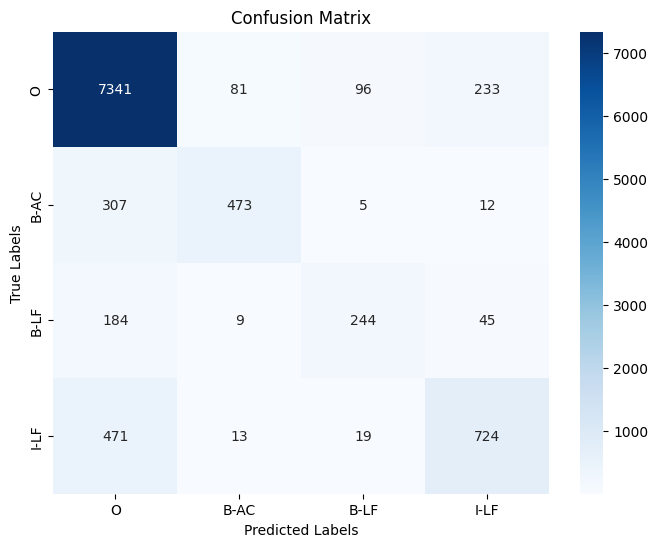

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm):
    labels = ['O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

cm = confusion_matrix(filtered_labels, filtered_preds)
plot_confusion_matrix(cm)


In [89]:
text_tokens = ["The", "patient", "was", "diagnosed", "with", "acute", "myeloid", "leukemia", "(", "AML", ")", "."]

In [90]:
# Prepare embedding vector for the tokens
embeddings = [word2vec_model[word] if word in word2vec_model else np.zeros(300) for word in text_tokens]

# Convert to tensor
input_tensor = torch.tensor([embeddings], dtype=torch.float).to(DEVICE)  # [1, seq_len, 300]

# Set model to eval
bilstm_model.eval()

# Predict
with torch.no_grad():
    outputs = bilstm_model(input_tensor)  # shape: [1, seq_len, tagset_size]
    predicted_tags = torch.argmax(outputs, dim=-1).squeeze(0).tolist()  # remove batch dim

In [91]:
# ID_TO_LABEL from your earlier steps
predicted_labels = [ID_TO_LABEL[tag_id] for tag_id in predicted_tags]

# Show result
for token, label in zip(text_tokens, predicted_labels):
    print(f"{token:15s} --> {label}")


The             --> O
patient         --> O
was             --> O
diagnosed       --> O
with            --> O
acute           --> B-LF
myeloid         --> I-LF
leukemia        --> I-LF
(               --> O
AML             --> B-AC
)               --> O
.               --> O


## Experiment 2.3.2: BiLSTM with GloVe

In [23]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

In [95]:
GloVe_dataset = PlodTokenDataset(data_train['tokens'], label_list, glove_model)
GloVe_dataloader = DataLoader(GloVe_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

GloVe_test_dataset = PlodTokenDataset(data_test['tokens'], test_label_list, glove_model)
GloVe_test_dataloader = DataLoader(GloVe_test_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [96]:
bilstm_glove_model = BiLSTM(embedding_dim=300, hidden_dim=150, tagset_size=4)

In [97]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(bilstm_glove_model.parameters(), lr=0.001)
loss_function = nn.NLLLoss(ignore_index=-1)  # Ignore padding index


for epoch in range(20):
    bilstm_glove_model.train()
    for batch in GloVe_dataloader:
        optimizer.zero_grad()
        inputs = batch["tokens"]
        labels = batch["labels"]

        outputs = bilstm_glove_model(inputs)
        loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.24448467791080475
Epoch 2, Loss: 0.18884357810020447
Epoch 3, Loss: 0.42850083112716675
Epoch 4, Loss: 0.3076819181442261
Epoch 5, Loss: 0.1303277313709259
Epoch 6, Loss: 0.2963511645793915
Epoch 7, Loss: 0.13306231796741486
Epoch 8, Loss: 0.14608950912952423
Epoch 9, Loss: 0.1299939602613449
Epoch 10, Loss: 0.06841026246547699
Epoch 11, Loss: 0.03839818388223648
Epoch 12, Loss: 0.1631590873003006
Epoch 13, Loss: 0.08786850422620773
Epoch 14, Loss: 0.07535765320062637
Epoch 15, Loss: 0.008727827109396458
Epoch 16, Loss: 0.0174211785197258
Epoch 17, Loss: 0.016296198591589928
Epoch 18, Loss: 0.05394342914223671
Epoch 19, Loss: 0.007153697777539492
Epoch 20, Loss: 0.005727272946387529


In [103]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["tokens"]
            labels = batch["labels"]

            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)

            # Flatten the predictions and true labels
            predicted = predicted.view(-1)
            labels = labels.view(-1)

            # Filter out padding labels
            valid_indices = labels != -1
            valid_labels = labels[valid_indices]
            valid_predicted = predicted[valid_indices]

            all_preds.extend(valid_predicted.tolist())
            all_labels.extend(valid_labels.tolist())

    return all_preds, all_labels

In [104]:
# Testing and evaluation for GloVe

bilstm_glove_model.eval()
glove_preds = []
glove_labels = []

with torch.no_grad():
    for batch in GloVe_test_dataloader:
        inputs = batch["tokens"]
        labels = batch["labels"]

        outputs = bilstm_glove_model(inputs)
        _, predicted = torch.max(outputs, -1)

        glove_preds.extend(predicted.view(-1).tolist())
        glove_labels.extend(labels.view(-1).tolist())

# Remove padding labels
filtered_preds = [p for p, l in zip(glove_preds, glove_labels) if l != -1]
filtered_labels = [l for l in glove_labels if l != -1]

print(classification_report(filtered_labels, filtered_preds))
print(confusion_matrix(filtered_labels, filtered_preds))


              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7751
           1       0.77      0.71      0.74       797
           2       0.74      0.65      0.69       482
           3       0.80      0.68      0.74      1227

    accuracy                           0.88     10257
   macro avg       0.80      0.75      0.77     10257
weighted avg       0.88      0.88      0.88     10257

[[7333  151   80  187]
 [ 230  562    4    1]
 [ 137    3  314   28]
 [ 346   14   27  840]]


In [105]:
 #For GloVe model predictions
accuracy_glove = accuracy_score(filtered_labels, filtered_preds)
precision_glove, recall_glove, f1_glove, _ = precision_recall_fscore_support(
    filtered_labels, filtered_preds, average='macro')

print("GloVe Model Performance:")
print(f"Accuracy: {accuracy_glove:.4f}")
print(f"Precision: {precision_glove:.4f}")
print(f"Recall: {recall_glove:.4f}")
print(f"F1-Score: {f1_glove:.4f}")

GloVe Model Performance:
Accuracy: 0.8822
Precision: 0.8039
Recall: 0.7468
F1-Score: 0.7732


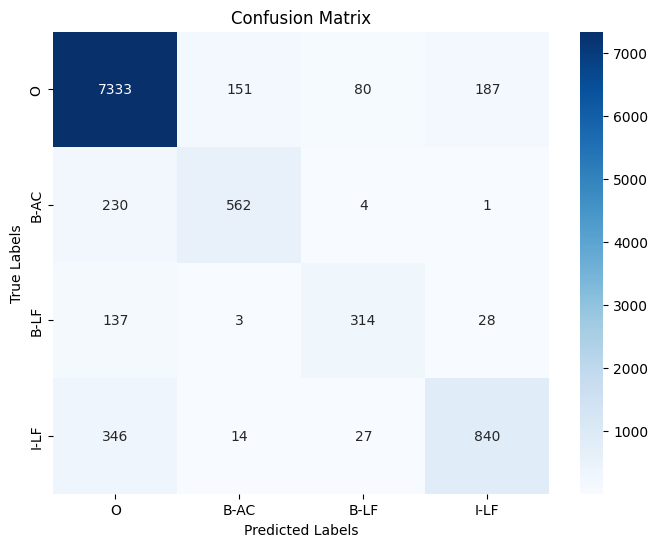

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm):
    labels = ['O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

cm = confusion_matrix(filtered_labels, filtered_preds)
plot_confusion_matrix(cm)

In [107]:
text_tokens = ["The", "patient", "was", "diagnosed", "with", "acute", "myeloid", "leukemia", "(", "AML", ")", "."]

# Prepare embedding vector for the tokens
embeddings = [glove_model[word] if word in glove_model else np.zeros(300) for word in text_tokens]

# Convert to tensor
input_tensor = torch.tensor([embeddings], dtype=torch.float).to(DEVICE)  # [1, seq_len, 300]

# Set model to eval
bilstm_glove_model.eval()

# Predict
with torch.no_grad():
    outputs = bilstm_glove_model(input_tensor)  # shape: [1, seq_len, tagset_size]
    predicted_tags = torch.argmax(outputs, dim=-1).squeeze(0).tolist()  # remove batch dim

# ID_TO_LABEL from your earlier steps (adjust as needed)
ID_TO_LABEL = {0: "O", 1: "B-AC", 2: "B-LF", 3: "I-LF"}

predicted_labels = [ID_TO_LABEL[tag_id] for tag_id in predicted_tags]

# Show result
for token, label in zip(text_tokens, predicted_labels):
    print(f"{token:15s} --> {label}")


The             --> O
patient         --> O
was             --> O
diagnosed       --> O
with            --> O
acute           --> B-LF
myeloid         --> I-LF
leukemia        --> I-LF
(               --> O
AML             --> B-AC
)               --> O
.               --> O


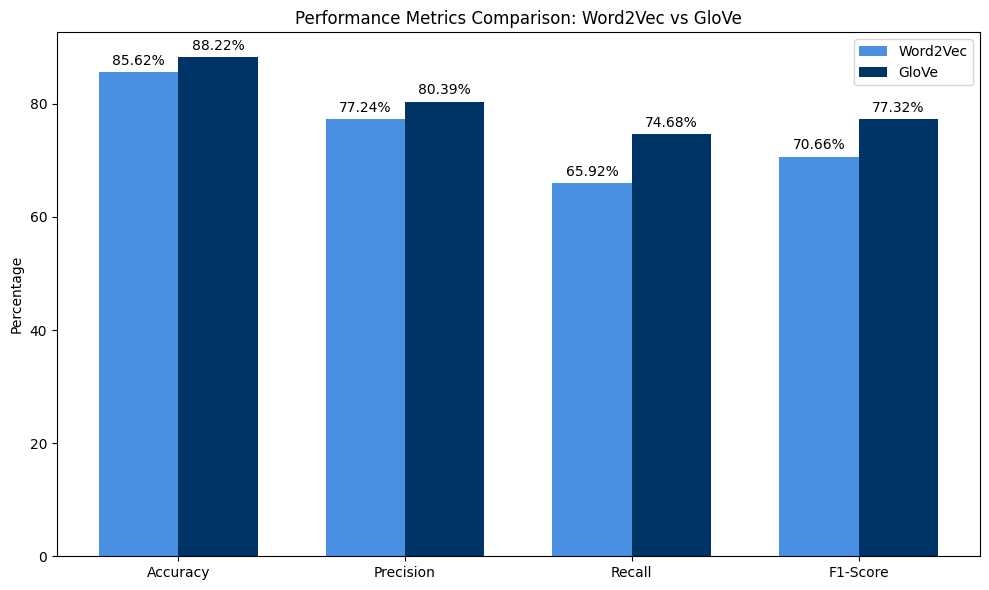

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Models and metrics labels
models = ['Word2Vec', 'GloVe']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Metrics values from your calculations
values_word2vec = [accuracy_w2v * 100, precision_w2v * 100, recall_w2v * 100, f1_w2v * 100]
values_glove = [accuracy_glove * 100, precision_glove * 100, recall_glove * 100, f1_glove * 100]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, values_word2vec, width, label='Word2Vec', color='#4A90E2')  
rects2 = ax.bar(x + width/2, values_glove, width, label='GloVe', color='#003366')       


# Add labels, title, and ticks
ax.set_ylabel('Percentage')
ax.set_title('Performance Metrics Comparison: Word2Vec vs GloVe')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add data labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


## Deployment

In [26]:
torch.save(model_C.state_dict(), "best_model.pt")

In [ ]:
import json

with open("token_vocab.json", "w") as f:
    json.dump(TOKEN_VOCAB, f)

with open("pos_vocab.json", "w") as f:
    json.dump(POS_VOCAB, f)

with open("id_to_label.json", "w") as f:
    json.dump(ID_TO_LABEL, f)
